In [7]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import nltk
import os
import pandas as pd

from scipy.stats import pearsonr
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import mean_squared_error

In [8]:
TRAIN_DATA = './datasets/sts-train.csv'
TEST_DATA = './datasets/sts-test.csv'
CWD = os.getcwd()

In [30]:
sts_dev = pd.read_table(
    TRAIN_DATA,
    error_bad_lines=False,
    skip_blank_lines=True,
    usecols=[4, 5, 6],
    names=["similarity", "S1", "S2"])

sts_test = pd.read_table(
    TEST_DATA,
    error_bad_lines=False,
    quoting=csv.QUOTE_NONE,
    skip_blank_lines=True,
    usecols=[4, 5, 6],
    names=["similarity", "S1", "S2"])

In [31]:
train_df = pd.concat([sts_dev, sts_test])

In [32]:
len(train_df)

7090

In [34]:
train_df['S2'] = [str(x) for x in train_df['S2']]

In [35]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
    return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
# embeddings produce a 512-length vector representing the sentence context
sample = train_df['S1'][0]
print (sample)
message_embeddings = embed([sample])
print (message_embeddings.shape)

0         A plane is taking off.
0    A girl is styling her hair.
Name: S1, dtype: object


### Qualitatively Evaluate Embeddings on a Small Sample by Plotting a Heatmap

In [13]:
# given sentence pairs that have been evaluated together create a heatmap
# features = sentence embeddings, labels = sentences
# first half corresponds to second half
def plot_similarity(labels, features, rotation):
    M = int(len(features) / 2)
    text_cutoff = 50
    
    labels = [label[:text_cutoff] for label in labels]
    corr = np.inner(features[:M], features[M:])
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels[:M],
      yticklabels=labels[M:],
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels[:M], rotation=rotation)
    g.set_title("Semantic Textual Similarity")
    g.get_figure().savefig("./sonia-mannan-sentence-embeddings-results/sample_heatmap.png", bbox_inches='tight')

def run_and_plot(messages_):
    message_embeddings_ = embed(messages_)
    plot_similarity(messages_, message_embeddings_, 90)

S(0         A plane is taking off.
0    A girl is styling her hair.
Name: S1, dtype: object, 0     An air plane is taking off.
0    A girl is brushing her hair.
Name: S2, dtype: object) = 5.0
S(1             A man is playing a large flute.
1    A group of men play soccer on the beach.
Name: S1, dtype: object, 1                           A man is playing a flute.
1    A group of boys are playing soccer on the beach.
Name: S2, dtype: object) = 3.8
S(2    A man is spreading shreded cheese on a pizza.
2    One woman is measuring another woman's ankle.
Name: S1, dtype: object, 2    A man is spreading shredded cheese on an uncoo...
2              A woman measures another woman's ankle.
Name: S2, dtype: object) = 3.8
S(3       Three men are playing chess.
3    A man is cutting up a cucumber.
Name: S1, dtype: object, 3      Two men are playing chess.
3    A man is slicing a cucumber.
Name: S2, dtype: object) = 2.6
S(4    A man is playing the cello.
4       A man is playing a harp.
Name: S1, dt

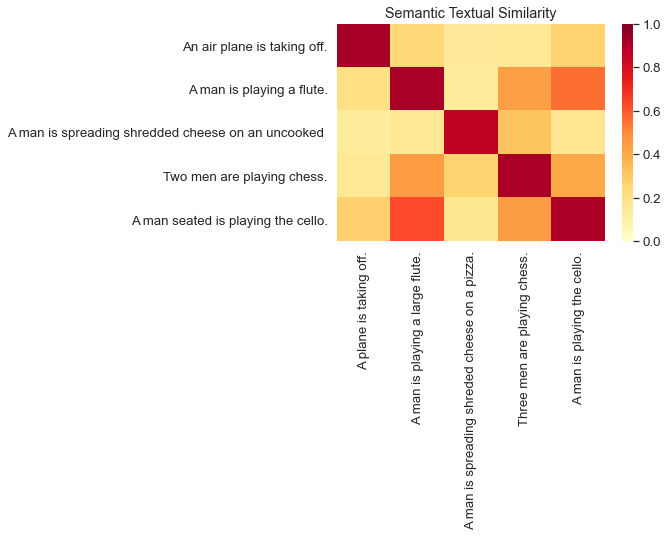

In [14]:
messages = list(train_df['S1'][:5]) + list(train_df['S2'][:5])
similarities = train_df['similarity'][:5]
for i in range(len(similarities)):
    print ('S({0}, {1}) = {2}'.format(train_df['S1'][i], train_df['S2'][i], similarities[i]))
run_and_plot(messages)

### Quantitively Evaluate Embeddings by Calculating Cosine Similarities

In [15]:
def magnitude(e1):
    return np.sqrt(np.sum(np.square(e1)))

In [16]:
def cosine_similarity(e1, e2):
    return (np.dot(e1, e2) / (magnitude(e1) * magnitude(e2)))

In [36]:
assert train_df['similarity'].shape[0] == train_df['S2'].shape[0] == train_df['S1'].shape[0]

# get embeddings for each sentence pair, 5,749 x 512
e1 = tf.nn.l2_normalize(embed(train_df['S1']), axis=1)
e2 = tf.nn.l2_normalize(embed(train_df['S2']), axis=1)

# take the cosine similarity between each embedding
calculated_similarities = np.array([cosine_similarity(x, y) for x, y in zip(e1, e2)])
actual_scores = train_df['similarity']

# calculate the pearson correlation
pearson_correlation = pearsonr(calculated_similarities, actual_scores)

### Pearson correlation measures similarity between two variables
1. -1 = opposite, 0 = neatral, 1 = same -> higher score means they are more similar. We expect the correlation between calculated and real scores to be high
2. Without dropping malformed lines: 0.64
3. With dropping malformed lines: 0.778


In [37]:
print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))

Pearson correlation coefficient = 0.7784817445535114
p-value = 0.0


#### We can also calculate the RMSE between calculated and real scores by interpolating calculated scores between 0-5
1. Perfect RMSE = 0
2. Random RMSE = 2.1492 -> randomly generate an array of 0-5
3. Actual RMSE = 1.167 -> not perfect but better than randomly guessing
4. Actual RMSE drop lines = 1.195

In [41]:
calculated_scores = np.interp(calculated_similarities, (calculated_similarities.min(), \
                                                        calculated_similarities.max()), (0, +5))
print ('Actual RMSE', mean_squared_error(actual_scores, calculated_scores, squared=False))

Actual RMSE 1.1954601701698726


In [42]:
print ('Perfect RMSE', mean_squared_error(actual_scores, actual_scores, squared=False))

Perfect RMSE 0.0


In [43]:
print ('Random RMSE', mean_squared_error(actual_scores, np.random.randint(5, size=len(actual_scores)), squared=False))

Random RMSE 2.162028148244892
